In [1]:
import os
import dask
import time
from distributed import Client
import dask.dataframe as dd
import pandas as pd
import io
import requests
import base64
import binascii
import numpy as np
import dask.bag as db
from numba import njit
import re
from glob import iglob
from scipy.interpolate import BarycentricInterpolator
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# url = 'https://cloud-areapd.pd.infn.it:5210/swift/v1/AUTH_d2e941ce4b324467b6b3d467a923a9bc/MAPD_miniDT_batch/'
# data_names = requests.get(url, verify = False).text
# data_names = data_names.split(sep = '\n')

In [4]:
client = Client()

In [5]:
client

Client Scheduler: tcp://127.0.0.1:39033 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 12.38 GiB


In [6]:
path = os.path.join('data_0000*.dat')
all_rec = iglob(path, recursive=True)
data_names = [i for i in all_rec]

In [7]:
def convert(mi):
    mat = np.zeros((mi.shape[0], 6), dtype = "u4")
    mat[:,0] = mi & 31 # tdc, 0-4 (5)
    mat[:,1] = (mi & 131040) >> 5 # bx, 5-16 (12)
    mat[:,2] = (mi & 562949953290240) >> 17 # orbit, 17-48 (32)
    mat[:,3] = (mi & 287667426198290432) >> 49 # chan, 49-57 (9)
    mat[:,4] = (mi & 2017612633061982208) >> 58 # fpga (3)
    mat[:,5] = mi >> 61
    return mat

def load_from_file(file): 
    m = np.fromfile(file, dtype = '<u8')
    mat = convert(m)
    return mat 

# b = db.from_sequence(data_names).map(load_from_file).flatten()

In [8]:
def load_from_file1(mi):
    m = np.fromfile(file, dtype = '<u8')
    mat = np.zeros((mi.shape[0], 6), dtype = "u4")
    mat[:,0] = mi & 31 # tdc, 0-4 (5)
    mat[:,1] = (mi & 131040) >> 5 # bx, 5-16 (12)
    mat[:,2] = (mi & 562949953290240) >> 17 # orbit, 17-48 (32)
    mat[:,3] = (mi & 287667426198290432) >> 49 # chan, 49-57 (9)
    mat[:,4] = (mi & 2017612633061982208) >> 58 # fpga (3)
    mat[:,5] = mi >> 61
    return mat

In [9]:
data_names1 = ['data_000000.dat', 'data_000001.dat']
data_names2 = ['data_000000.dat', 'data_000001.dat', 'data_000002.dat']
b = db.from_sequence(data_names1).map(load_from_file).flatten()

In [10]:
d = b.to_dataframe(meta = [('tdc', 'u1'), ('bx', 'u2'), ('orbit', 'u4'), ('chan', 'u2'), ('fpga', 'u1'), ('head', 'u1')])
d = d[d['head'] == 2]

In [12]:
cnt = d.orbit.value_counts().compute()
cnt = cnt[(cnt > 6) & (cnt < 17)]

In [13]:
d1 = d[d['orbit'].isin(cnt.index)] 

In [14]:
d3 = d1[d1['orbit'].isin(d1[((d1['fpga'] == 1) & (d1['chan'] == 128))].orbit.compute())]
d3.compute()

,tdc,bx,orbit,chan,fpga,head
6683,27,878,1118948,91,1,2
6687,8,882,1118948,107,0,2
6688,18,881,1118948,47,1,2
6689,12,884,1118948,88,1,2
6690,7,881,1118948,128,1,2
...,...,...,...,...,...,...
1305961,17,2877,10515923,42,1,2
1305962,11,2879,10515923,43,1,2
1305964,24,2875,10515923,107,0,2
1305965,20,2878,10515923,37,0,2


In [15]:
d3['time'] = 25 * (d3['bx'] + (d3['tdc']/30))

In [16]:
v1, v2 = np.unique((d3['orbit'][d3.chan == 128]).compute(), return_counts = True)
d5 = d3[d3.orbit.isin(v1[v2 < 2])]

In [17]:
d5 = d5.persist()

In [18]:
def t0(group):
    length=group.shape[0]
    scint=group[group["chan"]==128].time.values
    group=group.assign(t0=np.repeat(a=scint,repeats=length))
    return group

d5 = d5.groupby('orbit').apply(t0, meta = [('tdc', 'u1'),('bx', 'u2'),('orbit', 'u4'),('chan', 'u2'),('fpga', 'u1'),('head', 'u1'),
                                      ('time','u2'),('t0','u2')]).reset_index(drop=True)

In [19]:
d5.compute()

,tdc,bx,orbit,chan,fpga,head,time,t0
0,27,878,1118948,91,1,2,21972.500000,22030.833333
1,8,882,1118948,107,0,2,22056.666667,22030.833333
2,18,881,1118948,47,1,2,22040.000000,22030.833333
3,12,884,1118948,88,1,2,22110.000000,22030.833333
4,7,881,1118948,128,1,2,22030.833333,22030.833333
...,...,...,...,...,...,...,...,...
5805,17,2877,10515923,42,1,2,71939.166667,71715.833333
5806,11,2879,10515923,43,1,2,71984.166667,71715.833333
5807,24,2875,10515923,107,0,2,71895.000000,71715.833333
5808,20,2878,10515923,37,0,2,71966.666667,71715.833333


In [20]:
d5 = d5[d5['chan'] < 128]

In [21]:
tipi = {'tdc':'u1', 'bx':'u2', 'orbit':'u4', 'chan':'u2', 'fpga':'u1', 'head':'u1'}

In [22]:
# assegno la camera
d5['chamber'] = 23 # un numero a caso che però non è None (che non "entra" in un intero)
tipi2 = tipi
tipi2['chamber'] = 'u1'
d6 = d5.astype(tipi2)
# poichè le assegnazioni con gli oggetti di dask non si possono fare se come indici non sono forniti array e non dask promises costruisco una 
# lista di array booleani che rappresentano le condizioni per attribuire alle opportune righe le giuste chambers
masks=[((d6["fpga"]==0)&(d6["chan"]<64)),
       ((d6["fpga"]==0)&(d6["chan"]>63)),
       ((d6["fpga"]==1)&(d6["chan"]<64)),
       ((d6["fpga"]==1)&(d6["chan"]>63))]

for i,mask in enumerate(masks):
    d6["chamber"]=d6["chamber"].mask(mask,i)

In [23]:
#add layer column
#contando dal basso però partendo da uno non da zero 
d6['layer']=d6["chan"]%4
d6['layer'] = d6['layer'].replace({0:3, 3:0}) # 2:2, 1:1

# NELL ORIGINALE NELLA FUNZIONE REPLACE C'ERA INPLACE=TRUE, SU DASK NON E' SUPPORTATO PERTANTO E' NECESSARIO ASSEGNARE QUELLO CHE ABBIAMO 
# CALCOLATO CON REPLACE ALLA COLONNA CHE VOGLIAMO MODIFICARE (IN QUESTO CASO D6['LAYER'])

d6['layer'] += 1
# #add cell column
# d6["cell"]=d6["chan"]%64

#SAPPIAMO CHE QUESTA COLONNA CELL E' INUTILE 

In [24]:
d6.compute()

,tdc,bx,orbit,chan,fpga,head,time,t0,chamber,layer
0,27,878,1118948,91,1,2,21972.500000,22030.833333,3,1
1,8,882,1118948,107,0,2,22056.666667,22030.833333,1,1
2,18,881,1118948,47,1,2,22040.000000,22030.833333,2,1
3,12,884,1118948,88,1,2,22110.000000,22030.833333,3,4
5,14,881,1118948,44,1,2,22036.666667,22030.833333,2,4
...,...,...,...,...,...,...,...,...,...,...
5805,17,2877,10515923,42,1,2,71939.166667,71715.833333,2,3
5806,11,2879,10515923,43,1,2,71984.166667,71715.833333,2,1
5807,24,2875,10515923,107,0,2,71895.000000,71715.833333,1,1
5808,20,2878,10515923,37,0,2,71966.666667,71715.833333,0,2


In [25]:
def numero_chambers(gruppo):
    if gruppo.nunique()['chamber'] > 1:
        return gruppo
    else :
        return None
    
d6 = d6.groupby('orbit').apply(numero_chambers, meta = [('tdc', 'u1'), ('bx', 'u2'), ('orbit', 'u4'), ('chan', 'u2'), 
                                                       ('fpga', 'u1'), ('head', 'u1'), ('time', 'u2'), ('t0', 'u2'), ('chamber', 'u1'), 
                                                       ('layer', 'u1')]).reset_index(drop=True)

In [26]:
def numero_di_layers(gruppo):
    if gruppo.nunique()['layer'] > 2 :
        return gruppo
    else :
        return None
    
d6 = d6.groupby(['orbit', 'chamber']).apply(numero_di_layers, meta = [('tdc', 'u1'), ('bx', 'u2'), ('orbit', 'u4'), ('chan', 'u2'), 
                                                       ('fpga', 'u1'), ('head', 'u1'), ('time', 'u2'), ('t0', 'u2'), ('chamber', 'u1'), 
                                                       ('layer', 'u1')]).dropna().reset_index(drop = True)
d6.compute()

In [27]:
def stesso_layer(gruppo) :
    if gruppo['layer'].nunique() == len(gruppo) :
        return gruppo
    else :
        return None 

d7 = d6.groupby(['orbit', 'chamber']).apply(stesso_layer, meta = [('tdc', 'u1'), ('bx', 'u2'), ('orbit', 'u4'), ('chan', 'u2'), 
                                                       ('fpga', 'u1'), ('head', 'u1'), ('time', 'u2'), ('t0', 'u2'), ('chamber', 'u1'), 
                                                       ('layer', 'u1')]).dropna().reset_index(drop = True)
d7.compute()

,tdc,bx,orbit,chan,fpga,head,time,t0,chamber,layer
0,18,881,1118948,47,1,2,22040.000000,22030.833333,2,1
1,14,881,1118948,44,1,2,22036.666667,22030.833333,2,4
2,5,887,1118948,46,1,2,22179.166667,22030.833333,2,3
3,1,887,1118948,45,1,2,22175.833333,22030.833333,2,2
4,27,878,1118948,91,1,2,21972.500000,22030.833333,3,1
...,...,...,...,...,...,...,...,...,...,...
3698,20,2878,10515923,37,0,2,71966.666667,71715.833333,0,2
3699,17,2867,10515923,41,1,2,71689.166667,71715.833333,2,2
3700,29,2868,10515923,40,1,2,71724.166667,71715.833333,2,4
3701,17,2877,10515923,42,1,2,71939.166667,71715.833333,2,3


In [28]:
d7['chan'] = d7['chan'].mask((d7['chan'] > 63), other = d7['chan'] - 64)
d7.compute()

,tdc,bx,orbit,chan,fpga,head,time,t0,chamber,layer
0,18,881,1118948,47,1,2,22040.000000,22030.833333,2,1
1,14,881,1118948,44,1,2,22036.666667,22030.833333,2,4
2,5,887,1118948,46,1,2,22179.166667,22030.833333,2,3
3,1,887,1118948,45,1,2,22175.833333,22030.833333,2,2
4,27,878,1118948,27,1,2,21972.500000,22030.833333,3,1
...,...,...,...,...,...,...,...,...,...,...
3698,20,2878,10515923,37,0,2,71966.666667,71715.833333,0,2
3699,17,2867,10515923,41,1,2,71689.166667,71715.833333,2,2
3700,29,2868,10515923,40,1,2,71724.166667,71715.833333,2,4
3701,17,2877,10515923,42,1,2,71939.166667,71715.833333,2,3


In [29]:
f = BarycentricInterpolator([1,2,3,4],[1,3,2,4])

d7["column"] = ((d7['chan'] + d7["layer"]) / 4)

d7['column'] = d7['column'].mask(d7['layer'] == 2, other = (3 + d7['chan'])/4 )
d7['column'] = d7['column'].mask(d7['layer'] == 3, other = (2 + d7['chan'])/4 )

d7['column'] = d7['column'].astype('u1')

In [30]:
d7.compute()

,tdc,bx,orbit,chan,fpga,head,time,t0,chamber,layer,column
0,18,881,1118948,47,1,2,22040.000000,22030.833333,2,1,12
1,14,881,1118948,44,1,2,22036.666667,22030.833333,2,4,12
2,5,887,1118948,46,1,2,22179.166667,22030.833333,2,3,12
3,1,887,1118948,45,1,2,22175.833333,22030.833333,2,2,12
4,27,878,1118948,27,1,2,21972.500000,22030.833333,3,1,7
...,...,...,...,...,...,...,...,...,...,...,...
3698,20,2878,10515923,37,0,2,71966.666667,71715.833333,0,2,10
3699,17,2867,10515923,41,1,2,71689.166667,71715.833333,2,2,11
3700,29,2868,10515923,40,1,2,71724.166667,71715.833333,2,4,11
3701,17,2877,10515923,42,1,2,71939.166667,71715.833333,2,3,11


In [31]:
d8 = d7.copy()

In [32]:
centers_coords = np.vstack((np.arange(2,34,2),np.arange(1,33,2))) # ok. invertito è giusto come deve essere, ho fatto un check con le prime righe/colonne
centers_coords = np.vstack((centers_coords,centers_coords))
# d8["center"] = centers_coords[d7.layer-1,d7.column-1]
d8['center'] = d8['column']*2
d8['center'] = d8['center'].mask(d8['layer'] == 1, other = d8['center'] - 1)
d8['center'] = d8['center'].mask(d8['layer'] == 3, other = d8['center'] - 1)
d8.compute()

,tdc,bx,orbit,chan,fpga,head,time,t0,chamber,layer,column,center
0,18,881,1118948,47,1,2,22040.000000,22030.833333,2,1,12,23
1,14,881,1118948,44,1,2,22036.666667,22030.833333,2,4,12,24
2,5,887,1118948,46,1,2,22179.166667,22030.833333,2,3,12,23
3,1,887,1118948,45,1,2,22175.833333,22030.833333,2,2,12,24
4,27,878,1118948,27,1,2,21972.500000,22030.833333,3,1,7,13
...,...,...,...,...,...,...,...,...,...,...,...,...
3698,20,2878,10515923,37,0,2,71966.666667,71715.833333,0,2,10,20
3699,17,2867,10515923,41,1,2,71689.166667,71715.833333,2,2,11,22
3700,29,2868,10515923,40,1,2,71724.166667,71715.833333,2,4,11,22
3701,17,2877,10515923,42,1,2,71939.166667,71715.833333,2,3,11,21


In [33]:
time_offset = np.array([-1.1, 6.4, 0.5, -2.6])

d8['dt'] = d8['time'] - d8['t0'] + 95 #+ dd.from_array(time_offset[d8['layer'] - 1])

for i,to in enumerate(time_offset):
    d8['dt'] = d8['dt'].mask(d8['chamber'] == i, other = d8['dt'] + to) 
    
vd = 53.8*1e-3 # v_drift = 53.8 um/ns, voglio lavorare con i millimetri
d8['xr'] = d8['center']*21 + vd*d8['dt']
d8['xl'] = d8['center']*21 - vd*d8['dt']

z_offset = np.array([219.8, 977.3, 1035.6, 1819.8])
dz = 13

d8['z'] = (d8['layer'] - 0.5)*dz 

for i,zo in enumerate(z_offset):
    d8['z'] = d8['z'].mask(d8['chamber'] == i, other = d8['z'] + zo) 
    

In [34]:
d8.compute()

,tdc,bx,orbit,chan,fpga,head,time,t0,chamber,layer,column,center,dt,xr,xl,z
0,18,881,1118948,47,1,2,22040.000000,22030.833333,2,1,12,23,104.666667,232.631067,221.368933,1042.1
1,14,881,1118948,44,1,2,22036.666667,22030.833333,2,4,12,24,101.333333,253.451733,242.548267,1081.1
2,5,887,1118948,46,1,2,22179.166667,22030.833333,2,3,12,23,243.833333,240.118233,213.881767,1068.1
3,1,887,1118948,45,1,2,22175.833333,22030.833333,2,2,12,24,240.500000,260.938900,235.061100,1055.1
4,27,878,1118948,27,1,2,21972.500000,22030.833333,3,1,7,13,34.066667,18.832787,15.167213,1826.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3698,20,2878,10515923,37,0,2,71966.666667,71715.833333,0,2,10,20,344.733333,182.546653,145.453347,239.3
3699,17,2867,10515923,41,1,2,71689.166667,71715.833333,2,2,11,22,68.833333,209.703233,202.296767,1055.1
3700,29,2868,10515923,40,1,2,71724.166667,71715.833333,2,4,11,22,103.833333,211.586233,200.413767,1081.1
3701,17,2877,10515923,42,1,2,71939.166667,71715.833333,2,3,11,21,318.833333,202.153233,167.846767,1068.1


In [35]:
@njit 
def numba_score(combin,eventZ) :
    s = np.zeros(combin.shape[0]) 
    for i, c in enumerate(combin) :
        if ((eventZ - eventZ.mean())**2).sum() == 0 : # dice che se no ci sono delle divisioni per zero anche se non riesco a riprodurle a mano... assurdo
            s[i] = 0 #np.nan
        else :
            slope = ((eventZ - eventZ.mean())*(c - c.mean())).sum() / ((eventZ - eventZ.mean())**2).sum()
            intercept = c.mean() - slope*eventZ.mean() # cfr https://en.wikipedia.org/wiki/Simple_linear_regression con x e y scambiati

            s[i] = np.linalg.norm(c - (slope*eventZ+intercept))
    return s

def solve_ambiguity(event):
    combin = np.array(list(product(*event.loc[:, ['xr','xl']].to_numpy())))
    s = numba_score(combin,event.z.to_numpy())
    event['xb'] = combin[s.argmin()]
    return event

In [36]:
d9 = d8.copy()
d9 = d9.groupby(['orbit', 'chamber']).apply(solve_ambiguity, meta=[('tdc', 'u1'), ('bx', 'u2'), ('orbit', 'u4'), ('chan', 'u2'), 
                                                                   ('fpga', 'u1'), ('head', 'u1'), ('time', 'f8'), ('t0', 'f8'), 
                                                                   ('chamber', 'u1'), ('layer', 'u1'), ('column', 'u1'),
                                                                   ('center', 'u1'), ('dt', 'f8'), ('xr', 'f8'), ('xl', 'f8'),
                                                                   ('z', 'f8'), ('xb', 'f8')])

d9.compute()

,tdc,bx,orbit,chan,fpga,head,time,t0,chamber,layer,column,center,dt,xr,xl,z,xb
0,18,881,1118948,47,1,2,22040.000000,22030.833333,2,1,12,23,104.666667,232.631067,221.368933,1042.1,232.631067
1,14,881,1118948,44,1,2,22036.666667,22030.833333,2,4,12,24,101.333333,253.451733,242.548267,1081.1,242.548267
2,5,887,1118948,46,1,2,22179.166667,22030.833333,2,3,12,23,243.833333,240.118233,213.881767,1068.1,240.118233
3,1,887,1118948,45,1,2,22175.833333,22030.833333,2,2,12,24,240.500000,260.938900,235.061100,1055.1,235.061100
4,27,878,1118948,27,1,2,21972.500000,22030.833333,3,1,7,13,34.066667,18.832787,15.167213,1826.3,18.832787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3698,20,2878,10515923,37,0,2,71966.666667,71715.833333,0,2,10,20,344.733333,182.546653,145.453347,239.3,145.453347
3699,17,2867,10515923,41,1,2,71689.166667,71715.833333,2,2,11,22,68.833333,209.703233,202.296767,1055.1,202.296767
3700,29,2868,10515923,40,1,2,71724.166667,71715.833333,2,4,11,22,103.833333,211.586233,200.413767,1081.1,200.413767
3701,17,2877,10515923,42,1,2,71939.166667,71715.833333,2,3,11,21,318.833333,202.153233,167.846767,1068.1,202.153233


In [36]:
# PER VISUALIZZARE QUALCHE GRUPPO DI EVENTI CIOE' ALCUNE ORBITE PASSIAMO DEI SOTTO GRUPPI DEL DATAFRAME OTTENUTO A DEI PANDAS DATAFRAME 

In [37]:
df8 = d9.compute()

In [42]:
df8 = df8[:100]

In [ ]:
# FIT LOCALE 

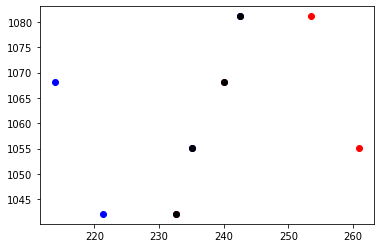

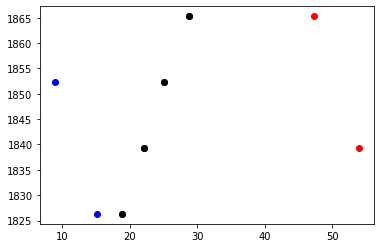

In [43]:
n = 0 # numero orbita da visualizzare
tmp = df8.loc[df8.orbit == df8.orbit.unique()[n]].sort_values('chamber')

# voglio una riga per camera, ciascuna contenente tutte le hits di quella camera

# vxr = tmp.xr.to_numpy().reshape((-1, 4))
# vxl = tmp.xl.to_numpy().reshape((-1, 4))
# vxb = tmp.xb.to_numpy().reshape((-1, 4))
# vz = tmp.z.to_numpy().reshape((-1, 4))
# for i in range(3) :
#     fig, ax = plt.subplots()
#     ax.scatter(vxl[i], vz[i], c = 'blue')
#     ax.scatter(vxr[i], vz[i], c = 'red')
#     ax.scatter(vxb[i], vz[i], c = 'black')

for ch in tmp.chamber.unique() :
    vxr = tmp[tmp.chamber == ch].xr
    vxl = tmp[tmp.chamber == ch].xl
    vxb = tmp[tmp.chamber == ch].xb
    vz = tmp[tmp.chamber == ch].z

    fig, ax = plt.subplots()
    ax.scatter(vxl, vz, c = 'blue')
    ax.scatter(vxr, vz, c = 'red')
    ax.scatter(vxb, vz, c = 'black')

In [45]:
# FIT GLOBALE IN 2D 

In [54]:
df2d = d9.copy() # pronti per il fit globale 2D; tolgo la camera 1 che è rilevante solo per quello 3d
df2d = df2d[df2d['chamber'] != 1]
df2d.compute()

,tdc,bx,orbit,chan,fpga,head,time,t0,chamber,layer,column,center,dt,xr,xl,z,xb
0,18,881,1118948,47,1,2,22040.000000,22030.833333,2,1,12,23,104.666667,232.631067,221.368933,1042.1,232.631067
1,14,881,1118948,44,1,2,22036.666667,22030.833333,2,4,12,24,101.333333,253.451733,242.548267,1081.1,242.548267
2,5,887,1118948,46,1,2,22179.166667,22030.833333,2,3,12,23,243.833333,240.118233,213.881767,1068.1,240.118233
3,1,887,1118948,45,1,2,22175.833333,22030.833333,2,2,12,24,240.500000,260.938900,235.061100,1055.1,235.061100
4,27,878,1118948,27,1,2,21972.500000,22030.833333,3,1,7,13,34.066667,18.832787,15.167213,1826.3,18.832787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3698,20,2878,10515923,37,0,2,71966.666667,71715.833333,0,2,10,20,344.733333,182.546653,145.453347,239.3,145.453347
3699,17,2867,10515923,41,1,2,71689.166667,71715.833333,2,2,11,22,68.833333,209.703233,202.296767,1055.1,202.296767
3700,29,2868,10515923,40,1,2,71724.166667,71715.833333,2,4,11,22,103.833333,211.586233,200.413767,1081.1,200.413767
3701,17,2877,10515923,42,1,2,71939.166667,71715.833333,2,3,11,21,318.833333,202.153233,167.846767,1068.1,202.153233


### Importantissimo ri-assicurarsi che ogni coppia orbita/camera contenga almeno 3 punti per il fit (cosa non più scontata avendo rimosso la camera 1)!! Se no possono esserci orbite con un solo punto che soddisfano z == z.mean() banalmente e che quindi presentano una divisione per zero !!

In [45]:
df2d.groupby('orbit').size()[df2d.groupby('orbit').size() > 2].index.compute()

UInt64Index([ 1118948,  1123056,  1126947,  1144838,  1190130,  1190501,
              1248672,  1252229,  1265108,  1273848,
             ...
             10388694, 10398680, 10416584, 10444861, 10456690, 10461215,
             10473147, 10498956, 10504895, 10515923],
            dtype='uint64', name='orbit', length=830)

In [55]:
S = df2d.groupby('orbit').size()
Si = S[S > 2].index.compute()
df2d = df2d[df2d.orbit.isin(Si)] # l'indice di S è orbit!!
df2d.compute()

,tdc,bx,orbit,chan,fpga,head,time,t0,chamber,layer,column,center,dt,xr,xl,z,xb
0,18,881,1118948,47,1,2,22040.000000,22030.833333,2,1,12,23,104.666667,232.631067,221.368933,1042.1,232.631067
1,14,881,1118948,44,1,2,22036.666667,22030.833333,2,4,12,24,101.333333,253.451733,242.548267,1081.1,242.548267
2,5,887,1118948,46,1,2,22179.166667,22030.833333,2,3,12,23,243.833333,240.118233,213.881767,1068.1,240.118233
3,1,887,1118948,45,1,2,22175.833333,22030.833333,2,2,12,24,240.500000,260.938900,235.061100,1055.1,235.061100
4,27,878,1118948,27,1,2,21972.500000,22030.833333,3,1,7,13,34.066667,18.832787,15.167213,1826.3,18.832787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3698,20,2878,10515923,37,0,2,71966.666667,71715.833333,0,2,10,20,344.733333,182.546653,145.453347,239.3,145.453347
3699,17,2867,10515923,41,1,2,71689.166667,71715.833333,2,2,11,22,68.833333,209.703233,202.296767,1055.1,202.296767
3700,29,2868,10515923,40,1,2,71724.166667,71715.833333,2,4,11,22,103.833333,211.586233,200.413767,1081.1,200.413767
3701,17,2877,10515923,42,1,2,71939.166667,71715.833333,2,3,11,21,318.833333,202.153233,167.846767,1068.1,202.153233


In [64]:
def filtro2d(gruppo) :
    if len(gruppo['chamber'].unique()) > 1 :
        return gruppo
    else : 
        return None
    
df2d_2 = df2d.groupby('orbit').apply(filtro2d, meta=[('tdc', 'u1'), ('bx', 'u2'), ('orbit', 'u4'), ('chan', 'u2'), 
                                                                   ('fpga', 'u1'), ('head', 'u1'), ('time', 'f8'), ('t0', 'f8'), 
                                                                   ('chamber', 'u1'), ('layer', 'u1'), ('column', 'u1'),
                                                                   ('center', 'u1'), ('dt', 'f8'), ('xr', 'f8'), ('xl', 'f8'),
                                                                   ('z', 'f8'), ('xb', 'f8')]).reset_index(drop = True)
df2d_2.compute()

,tdc,bx,orbit,chan,fpga,head,time,t0,chamber,layer,column,center,dt,xr,xl,z,xb
0,18,881,1118948,47,1,2,22040.000000,22030.833333,2,1,12,23,104.666667,232.631067,221.368933,1042.1,232.631067
1,14,881,1118948,44,1,2,22036.666667,22030.833333,2,4,12,24,101.333333,253.451733,242.548267,1081.1,242.548267
2,5,887,1118948,46,1,2,22179.166667,22030.833333,2,3,12,23,243.833333,240.118233,213.881767,1068.1,240.118233
3,1,887,1118948,45,1,2,22175.833333,22030.833333,2,2,12,24,240.500000,260.938900,235.061100,1055.1,235.061100
4,27,878,1118948,27,1,2,21972.500000,22030.833333,3,1,7,13,34.066667,18.832787,15.167213,1826.3,18.832787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1791,20,2878,10515923,37,0,2,71966.666667,71715.833333,0,2,10,20,344.733333,182.546653,145.453347,239.3,145.453347
1792,17,2867,10515923,41,1,2,71689.166667,71715.833333,2,2,11,22,68.833333,209.703233,202.296767,1055.1,202.296767
1793,29,2868,10515923,40,1,2,71724.166667,71715.833333,2,4,11,22,103.833333,211.586233,200.413767,1081.1,200.413767
1794,17,2877,10515923,42,1,2,71939.166667,71715.833333,2,3,11,21,318.833333,202.153233,167.846767,1068.1,202.153233


In [65]:
df2d_2 = df2d_2.persist()

In [66]:
@njit
def fit(z, x) : # ricorda: nel nostro fit (rispetto a wikipedia) si ha x -> z (variabile fissa/senza errore/senza osservazioni da confrontare con predizioni) e y -> x (tutto il contrario dell'altra)
    slope = ((z - z.mean())*(x - x.mean())).sum() / ((z - z.mean())**2).sum()
    intercept = x.mean() - slope * z.mean()
    return slope, intercept # geometricamente queste due sono "sbagliate" ma filosoficamente e numericamente no!
    # questi due parametri soddisfano l'equazione x = slope*z+intercept visto quanto detto sopra su x, y e z

In [58]:
df2d[df2d.orbit == df2d.orbit.unique().compute()[0]].compute()

# questo è il primo evento per esempio 

,tdc,bx,orbit,chan,fpga,head,time,t0,chamber,layer,column,center,dt,xr,xl,z,xb
0,18,881,1118948,47,1,2,22040.000000,22030.833333,2,1,12,23,104.666667,232.631067,221.368933,1042.1,232.631067
1,14,881,1118948,44,1,2,22036.666667,22030.833333,2,4,12,24,101.333333,253.451733,242.548267,1081.1,242.548267
2,5,887,1118948,46,1,2,22179.166667,22030.833333,2,3,12,23,243.833333,240.118233,213.881767,1068.1,240.118233
3,1,887,1118948,45,1,2,22175.833333,22030.833333,2,2,12,24,240.500000,260.938900,235.061100,1055.1,235.061100
4,27,878,1118948,27,1,2,21972.500000,22030.833333,3,1,7,13,34.066667,18.832787,15.167213,1826.3,18.832787
5,12,884,1118948,24,1,2,22110.000000,22030.833333,3,4,7,14,171.566667,47.230287,28.769713,1865.3,28.769713
6,17,883,1118948,26,1,2,22089.166667,22030.833333,3,3,7,13,150.733333,25.109453,8.890547,1852.3,25.109453
7,12,889,1118948,25,1,2,22235.000000,22030.833333,3,2,7,14,296.566667,53.955287,22.044713,1839.3,22.044713


In [67]:
def residui(gruppo) :
    slope, intercept = fit(gruppo['z'].to_numpy(), gruppo['xb'].to_numpy())
    gruppo['residui'] = gruppo['xb'] - slope*gruppo['z']-intercept # x osservato - x predetto
#     print(gruppo['orbit'].iloc[0])
    return gruppo 

df2d_3 = df2d_2.groupby('orbit').apply(residui, meta=[('tdc', 'u1'), ('bx', 'u2'),('orbit', 'u4'), ('chan', 'u2'), 
                                                                   ('fpga', 'u1'), ('head', 'u1'), ('time', 'f8'), ('t0', 'f8'), 
                                                                   ('chamber', 'u1'), ('layer', 'u1'), ('column', 'u1'),
                                                                   ('center', 'u1'), ('dt', 'f8'), ('xr', 'f8'), ('xl', 'f8'),
                                                                   ('z', 'f8'), ('xb', 'f8'), ('residui', 'f8')]).reset_index(drop = True)
df2d_3.compute()

,tdc,bx,orbit,chan,fpga,head,time,t0,chamber,layer,column,center,dt,xr,xl,z,xb,residui
0,18,881,1118948,47,1,2,22040.000000,22030.833333,2,1,12,23,104.666667,232.631067,221.368933,1042.1,232.631067,-9.976394
1,14,881,1118948,44,1,2,22036.666667,22030.833333,2,4,12,24,101.333333,253.451733,242.548267,1081.1,242.548267,10.550023
2,5,887,1118948,46,1,2,22179.166667,22030.833333,2,3,12,23,243.833333,240.118233,213.881767,1068.1,240.118233,4.583584
3,1,887,1118948,45,1,2,22175.833333,22030.833333,2,2,12,24,240.500000,260.938900,235.061100,1055.1,235.061100,-4.009955
4,27,878,1118948,27,1,2,21972.500000,22030.833333,3,1,7,13,34.066667,18.832787,15.167213,1826.3,18.832787,-10.447803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1791,20,2878,10515923,37,0,2,71966.666667,71715.833333,0,2,10,20,344.733333,182.546653,145.453347,239.3,145.453347,22.553411
1792,17,2867,10515923,41,1,2,71689.166667,71715.833333,2,2,11,22,68.833333,209.703233,202.296767,1055.1,202.296767,0.471893
1793,29,2868,10515923,40,1,2,71724.166667,71715.833333,2,4,11,22,103.833333,211.586233,200.413767,1081.1,200.413767,-3.926489
1794,17,2877,10515923,42,1,2,71939.166667,71715.833333,2,3,11,21,318.833333,202.153233,167.846767,1068.1,202.153233,-0.929331


In [68]:
df2dc = df2d_3.compute().copy()

In [69]:
def plot_global_fit(event) :
    vxb = event.xb.to_numpy()
    vz = event.z.to_numpy()

    slope, intercept = fit(vz, vxb) # faccio il fit solo con le x best!
    q = -intercept/slope 
    m = 1/slope # cfr notebook di Zanetti per vedere come "raddrizzare" GEOMETRICAMENTE la retta (riflessione ortogonale)

    fig, ax = plt.subplots()
    ax.scatter(vxb, vz, c = 'black')
    ax.plot(vxb, m*vxb + q)
    ax.set_title(f'orbit {event.orbit.iloc[0]}')
    ax.set_yticks(z_offset) # le altezze delle camere (le due centrali sono appiccicate)

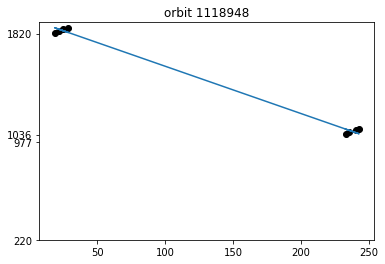

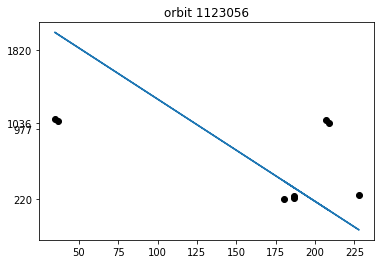

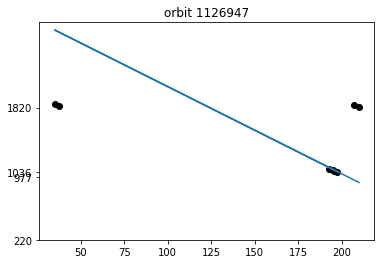

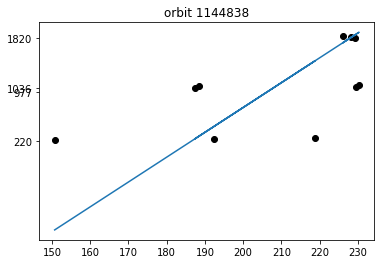

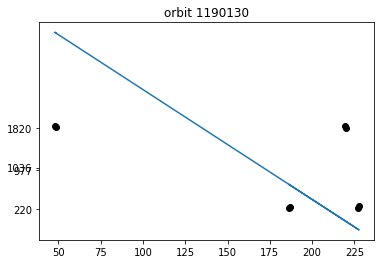

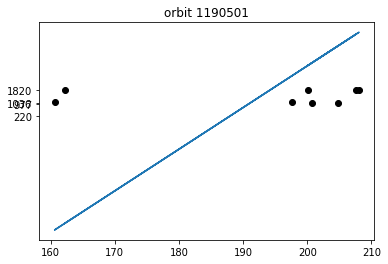

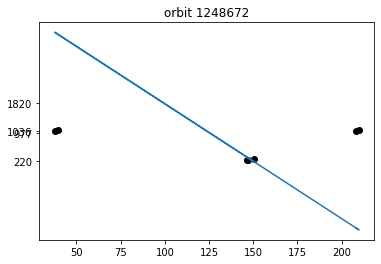

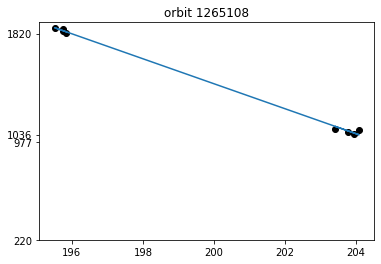

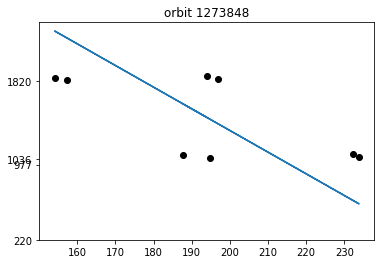

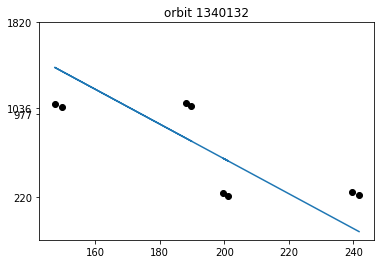

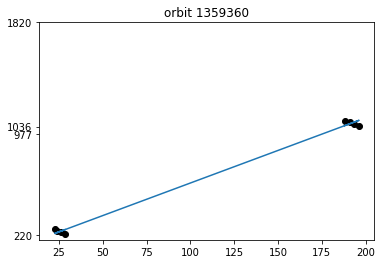

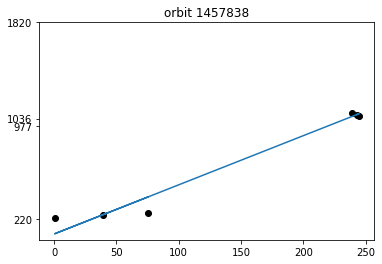

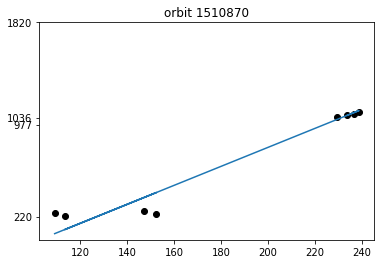

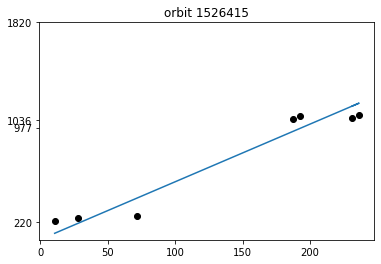

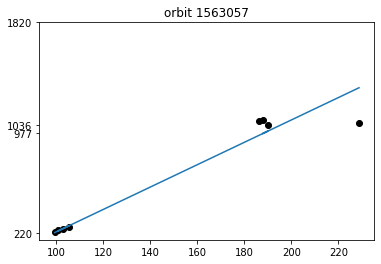

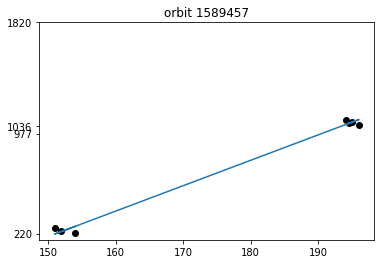

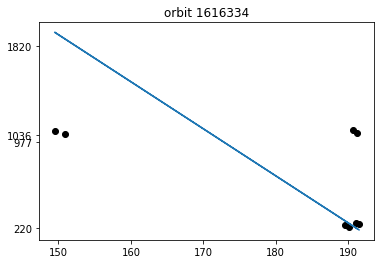

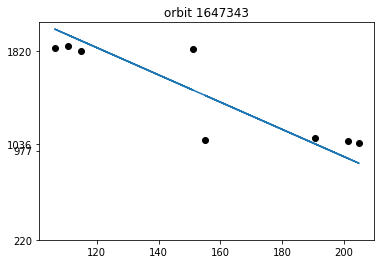

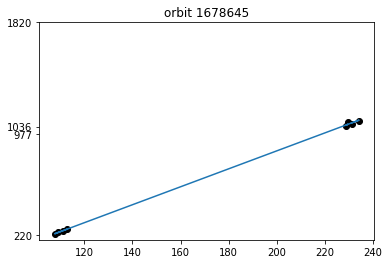

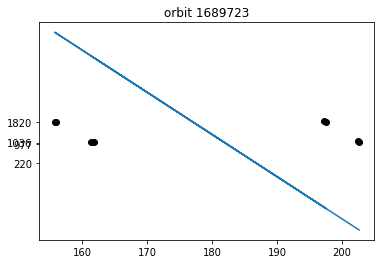

In [70]:
for i in range(20) :
    plot_global_fit(df2dc[df2dc.orbit == df2dc.orbit.unique()[i]])

## Serve la vicinanza orizzontale

In [86]:
df2d_3.compute()

,tdc,bx,orbit,chan,fpga,head,time,t0,chamber,layer,column,center,dt,xr,xl,z,xb,residui
0,18,881,1118948,47,1,2,22040.000000,22030.833333,2,1,12,23,104.666667,232.631067,221.368933,1042.1,232.631067,-9.976394
1,14,881,1118948,44,1,2,22036.666667,22030.833333,2,4,12,24,101.333333,253.451733,242.548267,1081.1,242.548267,10.550023
2,5,887,1118948,46,1,2,22179.166667,22030.833333,2,3,12,23,243.833333,240.118233,213.881767,1068.1,240.118233,4.583584
3,1,887,1118948,45,1,2,22175.833333,22030.833333,2,2,12,24,240.500000,260.938900,235.061100,1055.1,235.061100,-4.009955
4,27,878,1118948,27,1,2,21972.500000,22030.833333,3,1,7,13,34.066667,18.832787,15.167213,1826.3,18.832787,-10.447803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1791,20,2878,10515923,37,0,2,71966.666667,71715.833333,0,2,10,20,344.733333,182.546653,145.453347,239.3,145.453347,22.553411
1792,17,2867,10515923,41,1,2,71689.166667,71715.833333,2,2,11,22,68.833333,209.703233,202.296767,1055.1,202.296767,0.471893
1793,29,2868,10515923,40,1,2,71724.166667,71715.833333,2,4,11,22,103.833333,211.586233,200.413767,1081.1,200.413767,-3.926489
1794,17,2877,10515923,42,1,2,71939.166667,71715.833333,2,3,11,21,318.833333,202.153233,167.846767,1068.1,202.153233,-0.929331


In [155]:
def vicinanza(gruppo) :
    g = gruppo.sort_values('layer').astype({'center':'i1', 'layer':'i1'}) #FANCULO 
    if (g['layer'].diff().abs() > 1).any() or (g['center'].diff().abs() > 1).any() : 
        return None
    else : 
        return gruppo

In [156]:
df2d_4 = df2d_3.groupby(['orbit', 'chamfiltro2dapply(vicinanza, meta=[('tdc', 'u1'), ('bx', 'u2'), ('orbit', 'u4'), ('chan', 'u2'), 
                                                                   ('fpga', 'u1'), ('head', 'u1'), ('time', 'f8'), ('t0', 'f8'), 
                                                                   ('chamber', 'u1'), ('layer', 'u1'), ('column', 'u1'),
                                                                   ('center', 'u1'), ('dt', 'f8'), ('xr', 'f8'), ('xl', 'f8'),
                                                                   ('z', 'f8'), ('xb', 'f8'), ('residui', 'f8')]).dropna().reset_index(drop = True)
df2d_4.compute()

,tdc,bx,orbit,chan,fpga,head,time,t0,chamber,layer,column,center,dt,xr,xl,z,xb,residui
0,18.0,881.0,1118948.0,47.0,1.0,2.0,22040.000000,22030.833333,2.0,1.0,12.0,23.0,104.666667,232.631067,221.368933,1042.1,232.631067,-9.976394
1,14.0,881.0,1118948.0,44.0,1.0,2.0,22036.666667,22030.833333,2.0,4.0,12.0,24.0,101.333333,253.451733,242.548267,1081.1,242.548267,10.550023
2,5.0,887.0,1118948.0,46.0,1.0,2.0,22179.166667,22030.833333,2.0,3.0,12.0,23.0,243.833333,240.118233,213.881767,1068.1,240.118233,4.583584
3,1.0,887.0,1118948.0,45.0,1.0,2.0,22175.833333,22030.833333,2.0,2.0,12.0,24.0,240.500000,260.938900,235.061100,1055.1,235.061100,-4.009955
4,27.0,878.0,1118948.0,27.0,1.0,2.0,21972.500000,22030.833333,3.0,1.0,7.0,13.0,34.066667,18.832787,15.167213,1826.3,18.832787,-10.447803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,10.0,1131.0,10498956.0,5.0,1.0,2.0,28283.333333,27984.166667,3.0,2.0,2.0,4.0,391.566667,105.066287,62.933713,1839.3,62.933713,-2.943792
565,17.0,2867.0,10515923.0,41.0,1.0,2.0,71689.166667,71715.833333,2.0,2.0,11.0,22.0,68.833333,209.703233,202.296767,1055.1,202.296767,0.471893
566,29.0,2868.0,10515923.0,40.0,1.0,2.0,71724.166667,71715.833333,2.0,4.0,11.0,22.0,103.833333,211.586233,200.413767,1081.1,200.413767,-3.926489
567,17.0,2877.0,10515923.0,42.0,1.0,2.0,71939.166667,71715.833333,2.0,3.0,11.0,21.0,318.833333,202.153233,167.846767,1068.1,202.153233,-0.929331


In [159]:
df2d_4 = df2d_4.groupby('orbit').apply(filtro2d, meta=[('tdc', 'u1'), ('bx', 'u2'), ('orbit', 'u4'), ('chan', 'u2'), 
                                                                   ('fpga', 'u1'), ('head', 'u1'), ('time', 'f8'), ('t0', 'f8'), 
                                                                   ('chamber', 'u1'), ('layer', 'u1'), ('column', 'u1'),
                                                                   ('center', 'u1'), ('dt', 'f8'), ('xr', 'f8'), ('xl', 'f8'),
                                                                   ('z', 'f8'), ('xb', 'f8'), ('residui', 'f8')]).dropna().reset_index(drop = True)
df2d_4.compute()

,tdc,bx,orbit,chan,fpga,head,time,t0,chamber,layer,column,center,dt,xr,xl,z,xb,residui
0,18.0,881.0,1118948.0,47.0,1.0,2.0,22040.000000,22030.833333,2.0,1.0,12.0,23.0,104.666667,232.631067,221.368933,1042.1,232.631067,-9.976394
1,14.0,881.0,1118948.0,44.0,1.0,2.0,22036.666667,22030.833333,2.0,4.0,12.0,24.0,101.333333,253.451733,242.548267,1081.1,242.548267,10.550023
2,5.0,887.0,1118948.0,46.0,1.0,2.0,22179.166667,22030.833333,2.0,3.0,12.0,23.0,243.833333,240.118233,213.881767,1068.1,240.118233,4.583584
3,1.0,887.0,1118948.0,45.0,1.0,2.0,22175.833333,22030.833333,2.0,2.0,12.0,24.0,240.500000,260.938900,235.061100,1055.1,235.061100,-4.009955
4,27.0,878.0,1118948.0,27.0,1.0,2.0,21972.500000,22030.833333,3.0,1.0,7.0,13.0,34.066667,18.832787,15.167213,1826.3,18.832787,-10.447803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,24.0,257.0,6953168.0,40.0,1.0,2.0,6445.000000,6165.000000,2.0,4.0,11.0,22.0,375.500000,226.201900,185.798100,1081.1,185.798100,-4.097790
48,26.0,245.0,6953168.0,61.0,1.0,2.0,6146.666667,6165.000000,3.0,2.0,16.0,32.0,74.066667,163.984787,156.015213,1839.3,156.015213,0.061088
49,15.0,245.0,6953168.0,63.0,1.0,2.0,6137.500000,6165.000000,3.0,1.0,16.0,31.0,64.900000,142.491620,135.508380,1826.3,142.491620,-14.044466
50,6.0,251.0,6953168.0,60.0,1.0,2.0,6280.000000,6165.000000,3.0,4.0,16.0,32.0,207.400000,171.158120,148.841880,1865.3,171.158120,16.367917


In [160]:
df2df = df2d_4.compute().copy()

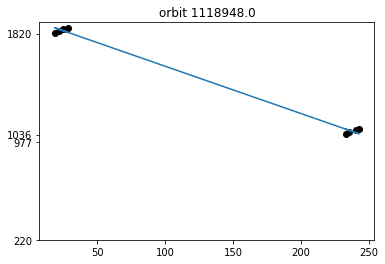

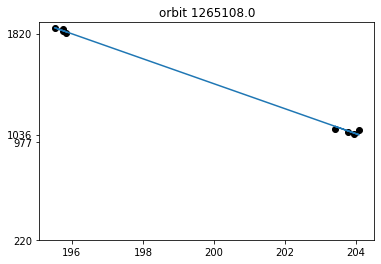

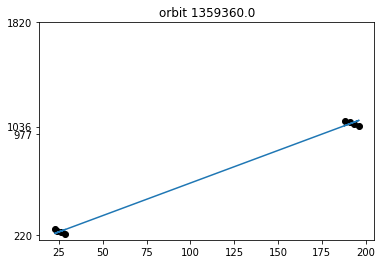

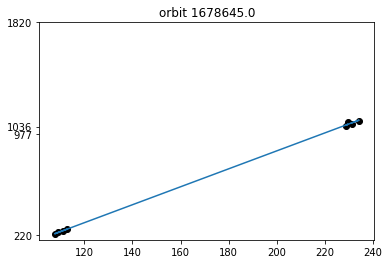

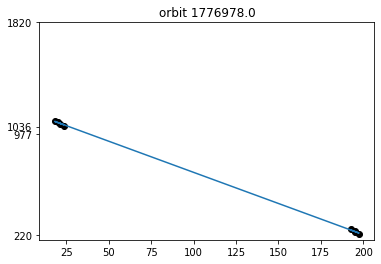

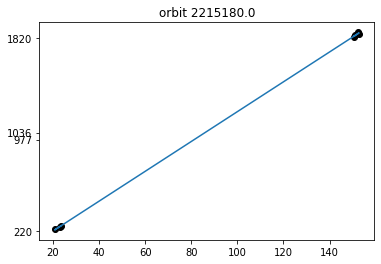

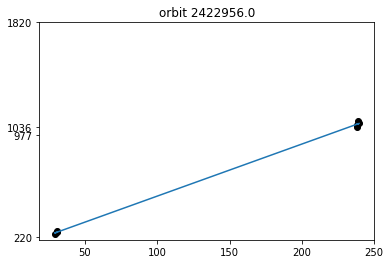

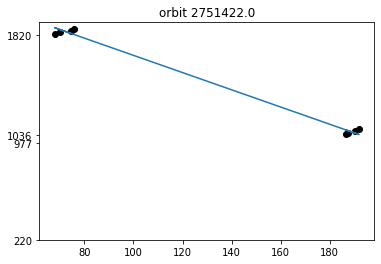

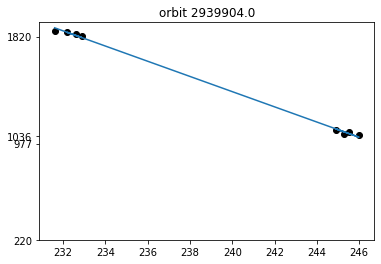

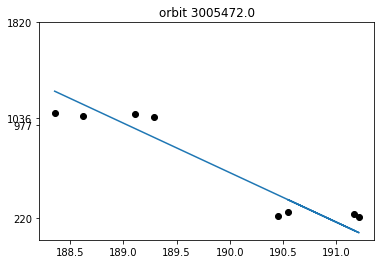

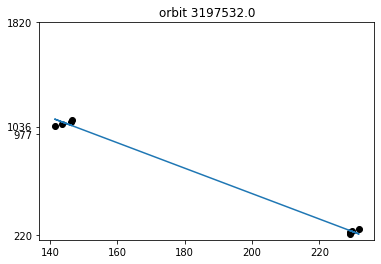

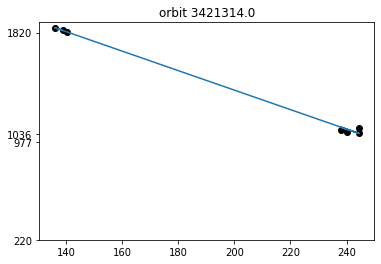

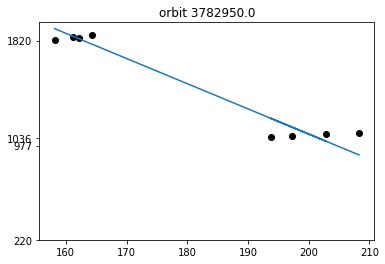

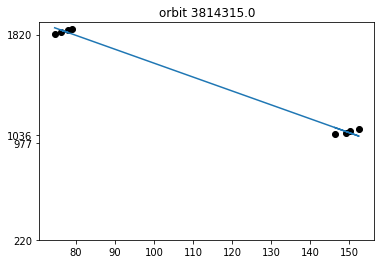

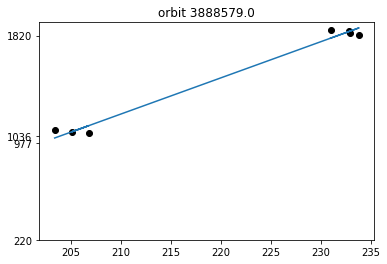

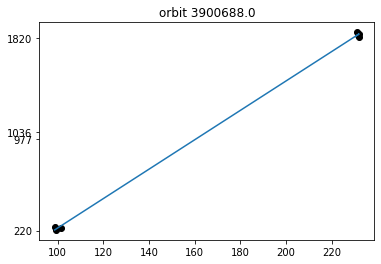

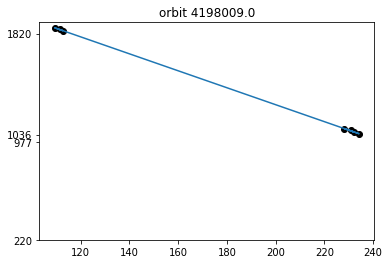

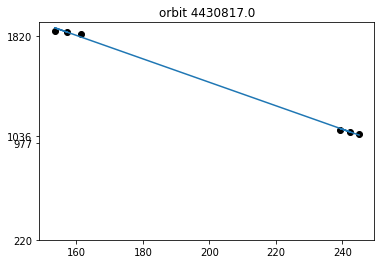

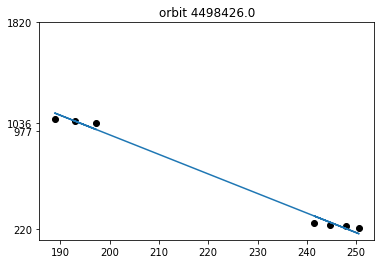

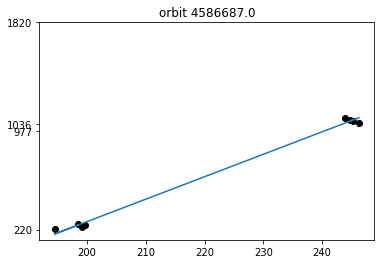

In [161]:
for i in range(20) :
    plot_global_fit(df2df[df2df.orbit == df2df.orbit.unique()[i]])

In [265]:
client.close()